In [11]:
!pip install pymysql tqdm

In [20]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt

# https://www.dunderdata.com/blog/view-all-available-matplotlib-styles
plt.style.use('fivethirtyeight')

# Hypothesis evaluation

In [3]:
# fetch data from acireale server
db_connection_str = 'mysql+pymysql://mlflow:<&gR4/);kt4G)d}f@acireale.iiar.pwr.edu.pl/mlflow'
db_connection = create_engine(db_connection_str)

In [4]:
%%time

query = '''
select
       r.run_uuid,
       p_agent.value as `agent`,
       p_hash.value as `hash`,
       p_modulo.value as `modulo`,
       p_rmpx.value as `rmpx`,
       m_pop.step as `step`,
       m_pop.value as `population`,
       m_perf_t.value as `perf_time`
from runs r
left join params p_agent on r.run_uuid = p_agent.run_uuid and p_agent.`key` = 'agent'
left join params p_rmpx on r.run_uuid = p_rmpx.run_uuid and p_rmpx.`key` = 'rmpx-size'
left join params p_modulo on r.run_uuid = p_modulo.run_uuid and p_modulo.`key` = 'modulo'
left join params p_hash on r.run_uuid = p_hash.run_uuid and p_hash.`key` = 'hash'
left join metrics m_pop on r.run_uuid = m_pop.run_uuid and m_pop.`key` = 'pop'
left join metrics m_perf_t on r.run_uuid = m_perf_t.run_uuid and m_pop.step = m_perf_t.step and m_perf_t.`key` = 'perf_time'
where
        r.status = 'FINISHED'
'''
df = pd.read_sql(query, con=db_connection)
df.set_index('step', inplace=True)

df['modulo'] = pd.to_numeric(df['modulo'])
df['rmpx'] = pd.to_numeric(df['rmpx'])

CPU times: user 4.85 s, sys: 308 ms, total: 5.16 s
Wall time: 4min 5s


In [135]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246000 entries, 25 to 50000
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   run_uuid    246000 non-null  object 
 1   agent       246000 non-null  object 
 2   hash        246000 non-null  object 
 3   modulo      246000 non-null  int64  
 4   rmpx        246000 non-null  int64  
 5   population  246000 non-null  float64
 6   perf_time   246000 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 59.1 MB


In [137]:
df.head()

,run_uuid,agent,hash,modulo,rmpx,population,perf_time
step,,,,,,,
25,001536bed1f24c5ea824b1fc7c26f63d,acs2ga,sha256,8,20,8.0,0.001307
50,001536bed1f24c5ea824b1fc7c26f63d,acs2ga,sha256,8,20,26.0,0.003864
75,001536bed1f24c5ea824b1fc7c26f63d,acs2ga,sha256,8,20,46.0,0.002219
100,001536bed1f24c5ea824b1fc7c26f63d,acs2ga,sha256,8,20,73.0,0.004565
125,001536bed1f24c5ea824b1fc7c26f63d,acs2ga,sha256,8,20,110.0,0.003186


### Validate grouping logic
Population and metric should be averaged for both `hash` methods

In [133]:
df.query('step == 25 and agent == "acs2" and rmpx == 3 and modulo == 4')

,run_uuid,agent,hash,modulo,rmpx,population,perf_time
step,,,,,,,
25,05396f52e5f3498d8695a4260628e3a5,acs2,sha256,4,3,10.0,0.000737
25,350c98dd7a11481c8b5e3f831e7bc996,acs2,md5,4,3,7.0,0.000655


In [138]:
def slice_and_average(df, agent, rmpx):
    sliced = df.query(f'agent == "{agent}" and rmpx == {rmpx}')
    sliced = sliced.groupby(['step', 'agent', 'modulo', 'rmpx']).mean()
    sliced.reset_index(inplace=True)
    sliced.set_index('step', inplace=True)
    return sliced

slice_and_average(df, 'acs2', 3).query('step == 25 and modulo == 4')

,agent,modulo,rmpx,population,perf_time
step,,,,,
25,acs2,4,3,8.5,0.000696


## H2. The population size stabilizes faster for smaller `MODULO` parameter.

(_Compare the population size and average trial execution time in the course of the experiment_)

In [9]:
def plot_pop_size(df, agent, rmpx, ax):
    sliced = slice_and_average(df, agent, rmpx)
    sliced.groupby('modulo')['population'].plot(legend=True, ax=ax)

    ax.set_title(f'{agent.upper()} - {rmpx} bit RMPX')
    ax.set_xlabel('Trial')

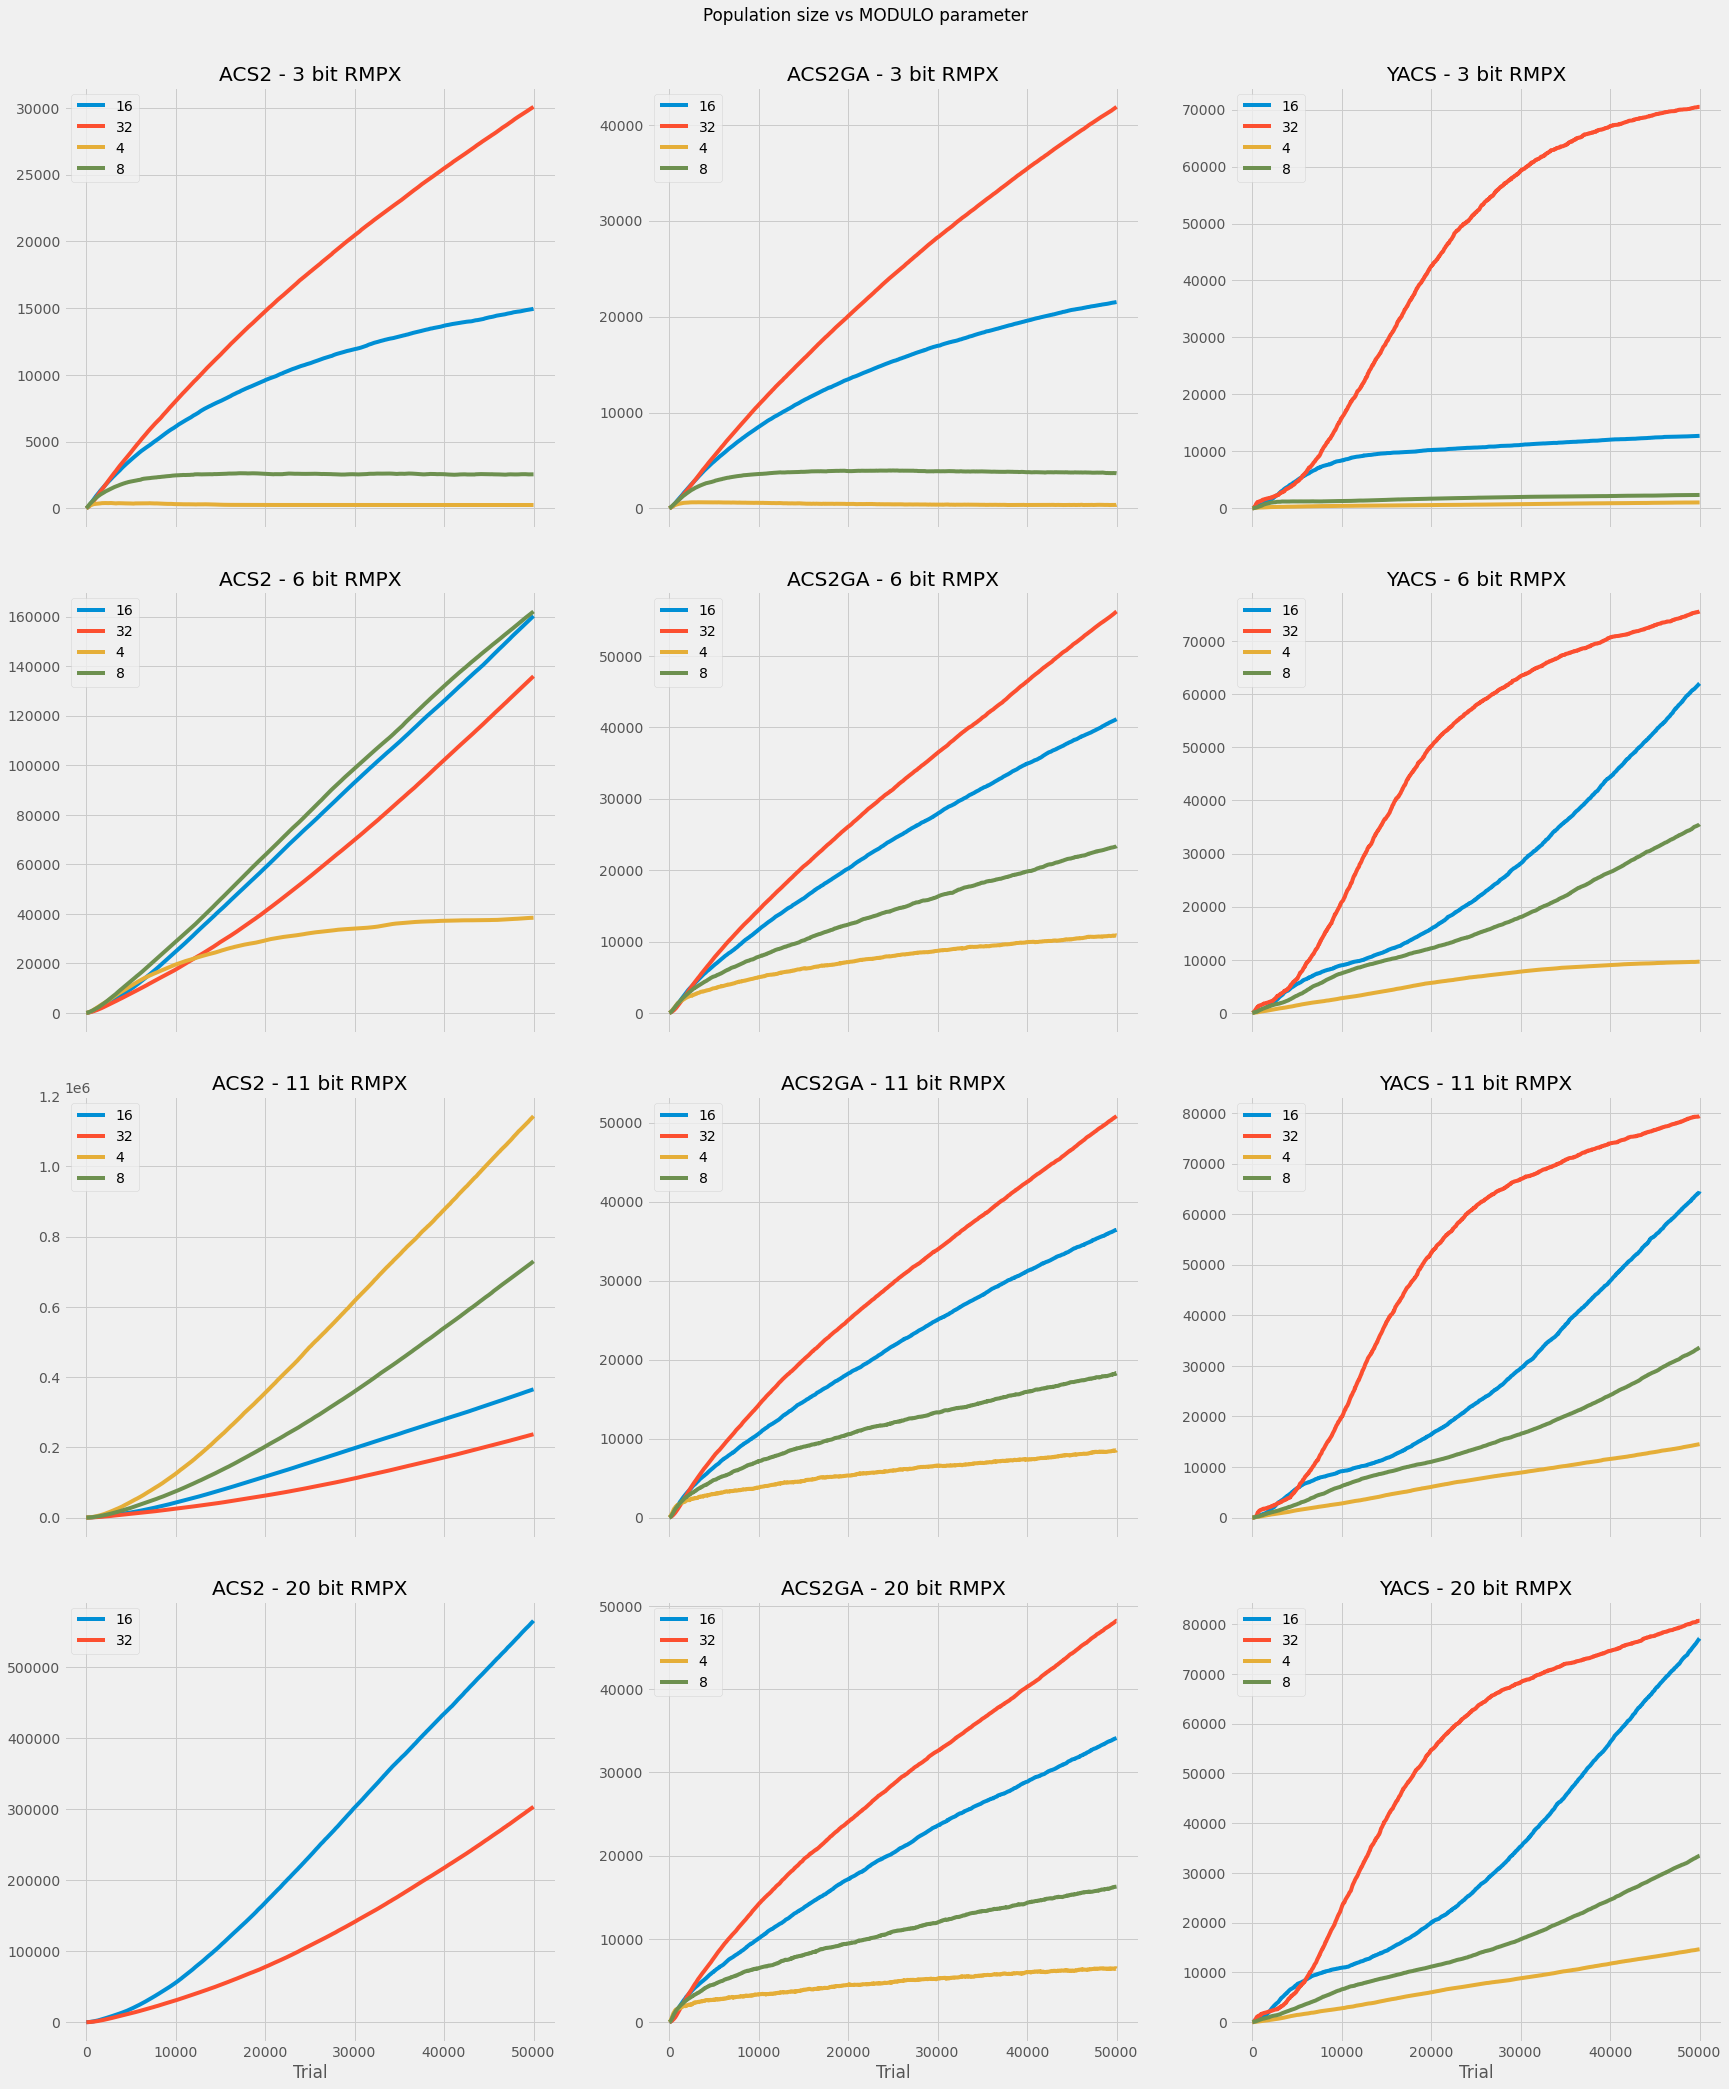

In [21]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(25, 30))
fig.suptitle('Population size vs MODULO parameter')

plot_pop_size(df, agent='acs2', rmpx=3, ax=ax[0][0])
plot_pop_size(df, agent='acs2ga', rmpx=3, ax=ax[0][1])
plot_pop_size(df, agent='yacs', rmpx=3, ax=ax[0][2])

plot_pop_size(df, agent='acs2', rmpx=6, ax=ax[1][0])
plot_pop_size(df, agent='acs2ga', rmpx=6, ax=ax[1][1])
plot_pop_size(df, agent='yacs', rmpx=6, ax=ax[1][2])

plot_pop_size(df, agent='acs2', rmpx=11, ax=ax[2][0])
plot_pop_size(df, agent='acs2ga', rmpx=11, ax=ax[2][1])
plot_pop_size(df, agent='yacs', rmpx=11, ax=ax[2][2])

plot_pop_size(df, agent='acs2', rmpx=20, ax=ax[3][0])
plot_pop_size(df, agent='acs2ga', rmpx=20, ax=ax[3][1])
plot_pop_size(df, agent='yacs', rmpx=20, ax=ax[3][2])

fig.tight_layout(pad=3.0)

plt.savefig('pop_vs_modulo.pdf', dpi=600)
plt.show()

## H3. The selection of hashing function has no significant impact on population size, performance or execution time

_(Last step)_

In [139]:
# Percentage Difference metric
def pct_diff(x1, x2):
    return abs(x1 - x2) / (0.5 * (x1 + x2)) * 100

print(pct_diff(2, 5))
print(pct_diff(5, 2))

85.71428571428571
85.71428571428571


In [150]:
# df.query(f'modulo == 4 and agent != "acs"').groupby(['agent', 'hash', 'rmpx']).last('step').sort_values(by=['rmpx', 'agent', 'hash'])
def foo(group):
    population_pct_diff = np.nan
    perf_time_pct_diff = np.nan

    if len(group) == 2:
        first = group.iloc[0]
        second = group.iloc[1]

        population_pct_diff = pct_diff(first['population'], second['population'])
        perf_time_pct_diff = pct_diff(first['perf_time'], second['perf_time'])

    group['perf_time_pct_diff'] = perf_time_pct_diff
    group['population_pct_diff'] = population_pct_diff

    return group

a = df.query(f'modulo == 4 and agent != "acs"').groupby(['agent', 'hash', 'rmpx']).last('step').reset_index()
a = a.groupby(['agent', 'rmpx']).apply(foo)
a.sort_values(by=['rmpx', 'agent', 'hash'])

,agent,hash,rmpx,modulo,population,perf_time,perf_time_pct_diff,population_pct_diff
0,acs2,md5,3,4,256.0,0.002646,45.079237,0.000000
2,acs2,sha256,3,4,256.0,0.001672,45.079237,0.000000
5,acs2ga,md5,3,4,366.0,0.002663,48.333447,0.816327
9,acs2ga,sha256,3,4,369.0,0.004361,48.333447,0.816327
13,yacs,md5,3,4,1034.0,0.022466,37.925835,1.153846
17,yacs,sha256,3,4,1046.0,0.032981,37.925835,1.153846
1,acs2,md5,6,4,38592.0,0.281224,8.849748,0.733401
3,acs2,sha256,6,4,38310.0,0.257391,8.849748,0.733401
6,acs2ga,md5,6,4,10871.0,0.089596,49.601049,0.092030
10,acs2ga,sha256,6,4,10861.0,0.053987,49.601049,0.092030


In [61]:
df.query(f'step == 50000 and modulo == 4 and agent != "acs"').sort_values(by=['rmpx', 'agent', 'hash'])

,run_uuid,agent,hash,modulo,rmpx,population,perf_time
step,,,,,,,
50000,350c98dd7a11481c8b5e3f831e7bc996,acs2,md5,4,3,256.0,0.002646
50000,05396f52e5f3498d8695a4260628e3a5,acs2,sha256,4,3,256.0,0.001672
50000,30ca4c12389542559ec2c9361d21eedc,acs2ga,md5,4,3,366.0,0.002663
50000,8778a7f48a394ba194753826acfa1afd,acs2ga,sha256,4,3,369.0,0.004361
50000,68d82242dfab48eba410ae0c44c63d7f,yacs,md5,4,3,1034.0,0.022466
50000,a2561fa2d5624248aefe1438cc52e7b1,yacs,sha256,4,3,1046.0,0.032981
50000,f3b5fa3190ac46c483d43b906f96db4c,acs2,md5,4,6,38592.0,0.281224
50000,0f79363f973d4f02952cc6ce354ff76f,acs2,sha256,4,6,38310.0,0.257391
50000,2a8a22f7c7804bf499e0dd57f52a63d1,acs2ga,md5,4,6,10871.0,0.089596


In [ ]:
def slice_and_last(df, agent, rmpx):
    sliced = df.query(f'agent == "{agent}" and rmpx == "{rmpx}"')
    sliced = sliced.groupby(['step', 'agent', 'modulo', 'rmpx']).mean()
    sliced.reset_index(inplace=True)
    sliced.set_index('step', inplace=True)
    return sliced

slice_and_average(df, 'acs2', 3).query('step == 25 and modulo == "4"')

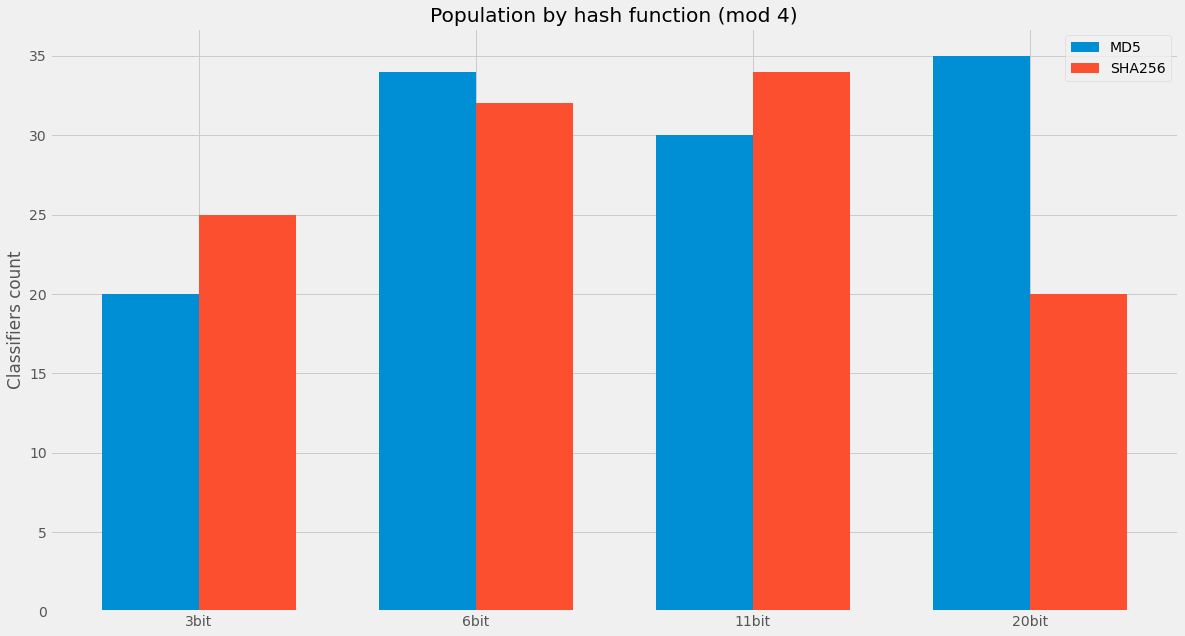

In [30]:
labels = ['3bit', '6bit', '11bit', '20bit']
men_means = [20, 34, 30, 35]
women_means = [25, 32, 34, 20]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18, 10))

rects1 = ax.bar(x - width/2, men_means, width, label='MD5')
rects2 = ax.bar(x + width/2, women_means, width, label='SHA256')


ax.set_ylabel('Classifiers count')
ax.set_title('Population by hash function (mod 4)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# fig.tight_layout()

plt.show()
